# Imports

In [1]:
#%run /Home/siv30/wad005/master/GRB/xspec/FERMI/fermi_functions.ipynb
%run /Users/andreas/phys/master/GRB/xspec/FERMI/fermi_functions.ipynb


All MAC paths are set!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
FERMI functions loaded successfully!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re, sys

from astropy.io import fits, ascii
from astropy.time import Time
from stingray import Lightcurve as LC
from stingray import CrossCorrelation
from dateutil import parser

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
from gbm.data.primitives import EventList
%matplotlib inline

CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# Notes on GRB

# Paths

In [4]:
GRB_id = "GRB181222B"
bn='bn181222841' #
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open
print(data_dir)

/Users/andreas/phys/master/FERMI/data//bn181222841/


# Find the angle of the GRB wrt the GBM units

In [5]:
fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

glg_trigdat_all_bn181222841_v01.fit
567202302.438436
['n2', 'n3', 'n4', 'n6', 'n7']


In [8]:
grb_ra, grb_dec = 312.572, 24.24 #angles declared are reported by the IPN. Reported in icecube: 312.2708, 22.8800. Ask MM & Anastasia

In [9]:
all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


n4 27.565
n3 27.921
n7 56.508
n8 57.998
n6 58.697
b0 71.024
n5 73.946
n0 75.189
n1 88.347
nb 105.75
n9 107.443
b1 108.976
n2 123.682
na 152.811


# Find temporal offset between GBM trigger time and others

from gbm.time import Met
import datetime

# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?
print(t0METgbm)
print(tshift)
print(t0METgbm-tshift)


ToF_Fermi_ASIM = -0.0008 #light travel time in seconds
ToF_KW_ASIM = 0.7142 
str_t0KW = '2020-12-27T15:14:06.705' #T0 for KW
t0METKW = t0METgbm.from_iso(str_t0KW) #Converting T0 KW to T0 met

#Q: Why are we adding both ToF? Double check this
t0MET = t0METKW.add(ToF_KW_ASIM+ToF_Fermi_ASIM)  # To add seconds
tshift = t0MET - t0METgbm
print(tshift) #shift between KW trigger and GBM trigger is <4ms 
print(t0METgbm-tshift)


#  Extract data from selected unit(s)+

In [37]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

n4


In [38]:
tte = TTE.open(fn_tte)
bint = 0.002 # 2ms binning

# certain useful properties are easily accessible
print("GTI: {}".format(tte.gti))
print("Trigger time: {}".format(tte.trigtime))
print("Time Range: {}".format(tte.time_range))
print("Energy Range: {}".format(tte.energy_range))
#print('# of Energy Channels: {}'.format(tte.numchan))

GTI: [[-135.5380140542984, 478.8732259273529]]
Trigger time: 567202302.438436
Time Range: (-135.5380140542984, 478.8732259273529)
Energy Range: (4.3384, 2000.0)


# KW lc

0.512


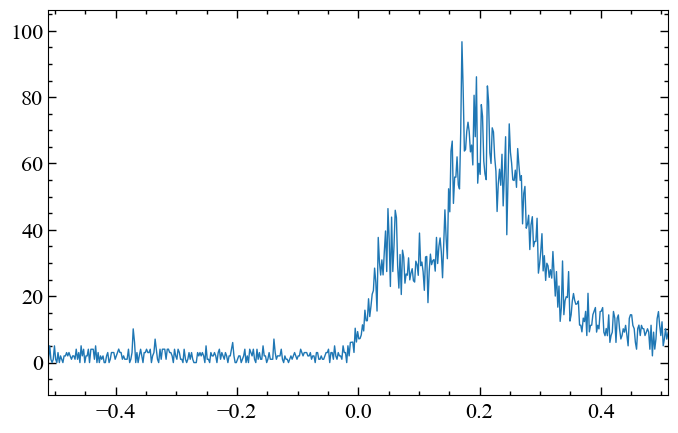

In [45]:
kw_filename = "GRB181222B_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G1
kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# FERMI lc

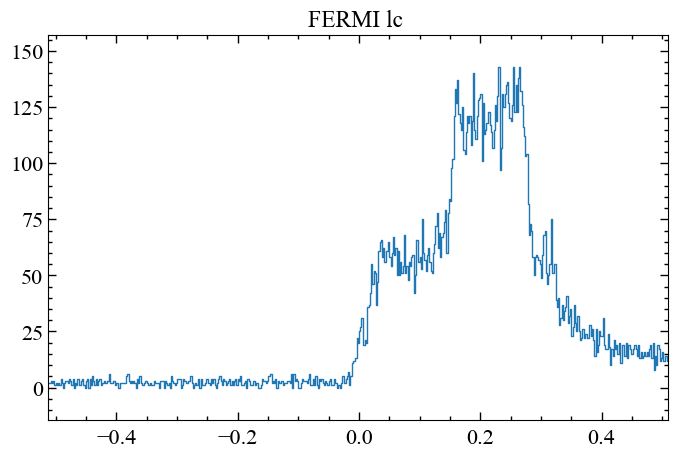

In [46]:
tus = tte.data.time

hist = np.histogram(tus,bins=np.append(kw_bin_lo,kw_bin_hi[-1]))
fermiCounts,fermiEdges = hist[0],hist[1]

plt.step(x=fermiEdges[:-1],y=fermiCounts,where="post")
plt.title("FERMI lc ")
plt.show()

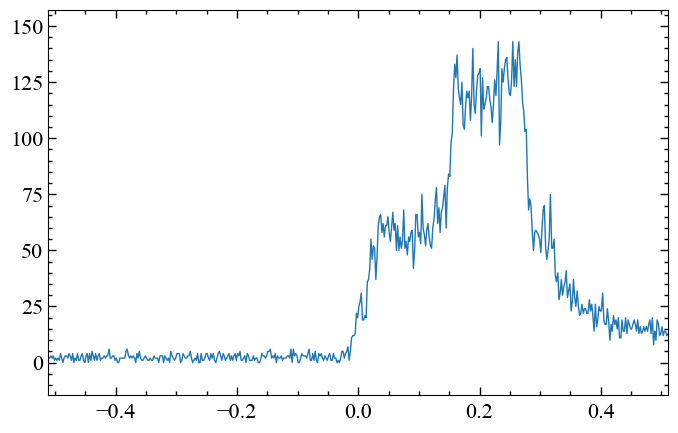

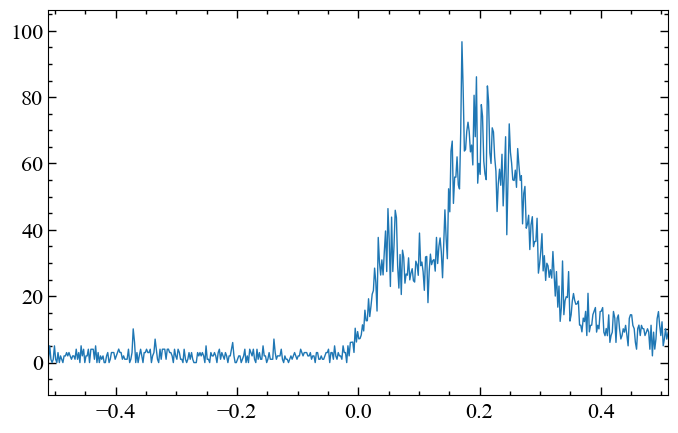

In [47]:
fermi_lc = LC(time=np.round(kw_bin_lo+binsize/2, 3), counts=fermiCounts, skip_checks=True,dt=binsize)
fermi_lc.plot()
kw_lc.plot()

# Overlapping lc's

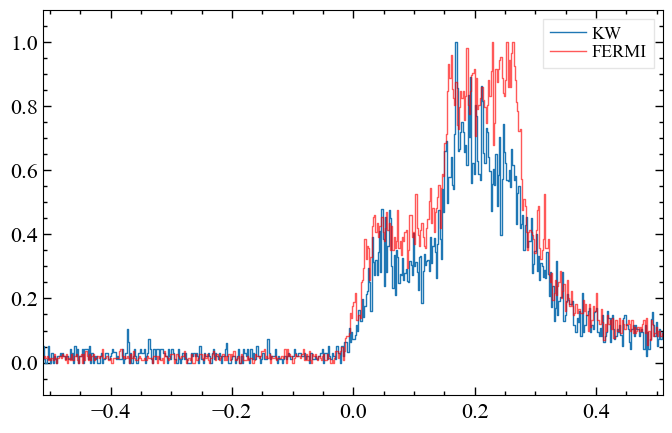

In [48]:
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),label='KW')
plt.step(x=kw_bin_lo,y=fermiCounts/max(fermiCounts),label='FERMI',c='r',alpha=0.65)
plt.legend()
plt.show()

# CC
    Looks good from the overlapping LC's.
    CC returns tlagg = 0.00 s!
    
    Find out why my own crossCorrolate function return -0.008 s (4 bins)
    Shift the fermiLC by 4 bins to see if its better.
        >> using different bins might be the reason
        
        >> Tried to shift, and the result is not good at all
        Seems like the original tte array is well aligned with KW
    

Total lagg (s):  0.0


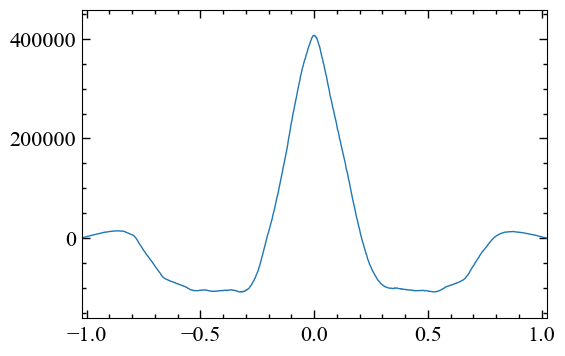

In [49]:
CC = CrossCorrelation(kw_lc,fermi_lc,mode="full")
CClagg=CC.time_shift
tlagg = CClagg
print("Total lagg (s): ", tlagg)
CC.plot()

# New TTE object

In [50]:

#tlagg = -0.004
#shiftedTTE = shiftTTE(tte=tte.data.time,tlagg=tlagg)
#newTTE = createNewTTE(oldTTEObj=tte,shiftedTTE=shiftedTTE,tlagg=tlagg,
#                      binsize=bint,
#                      unit=unit,
#                      obj=GRB_id,
#                      grb_ra=grb_ra,
#                      grb_dec=grb_dec)

phaii = tte.to_phaii(bin_by_time,bint) #changed to tte from newTTE

In [19]:
tte.trigtime #,newTTE.trigtime

567202302.438436

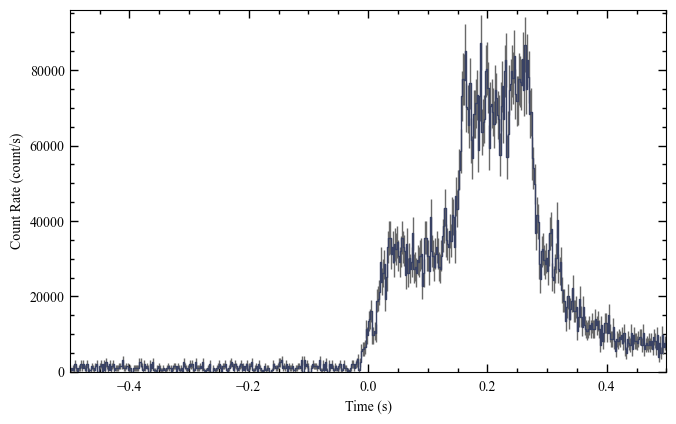

In [51]:
erange = (8, 1e3) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange) #lightcurve binned by the given bint?
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,.5)

In [52]:
#lcplot.fig.savefig("/Home/siv30/wad005/Downloads/GRB201227A_FERMI.png")

In [53]:
# Fit background
bkgd_times = [(-50, -10), (100,150)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

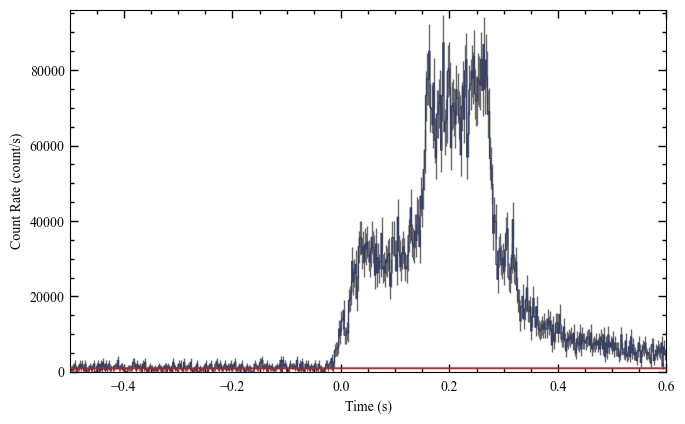

In [54]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-0.5,0.6)
lcplot.xlim = view_range

In [55]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([367.34147167,  93.48624156,  88.18556643,  79.0595149 ,
        56.64931913,  46.97444279,  32.12552117,  21.86992431,
        18.2362521 ,  15.37592038,  15.74996762,  14.79947955,
        15.19728756,  14.80621403,  13.61608275,  15.25316306,
        14.99719568,  15.9992358 ,  17.86960057,  19.09418638,
        16.61064614,  15.93197524,  17.34591317,  19.64448864,
        25.70564491,  29.11620931,  35.24002476,  38.89173521,
        43.26436553,  41.3294735 ,  44.60575081,  45.85926671,
        46.31140325,  42.38940703,  47.27782135,  51.74241241,
        50.97307873,  50.76363062,  46.16029708,  42.16031497,
        43.28484996,  52.23516853,  57.86126026,  62.73861823,
        64.26779703,  71.99321323,  67.49085126,  72.12777029,
        73.43151803,  80.42215488,  77.38657292,  88.42741605,
        86.14891463,  90.61500668,  93.46606697, 102.46651225,
        95.45707477,  99.21936852, 103.78449759, 120.92169808,
       110.39886501, 121.37987001, 112.02676459,  99.99

In [56]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

Normalised residuals: mean= 0.000963  std= 1
NormaltestResult(statistic=3143.2112877587347, pvalue=0.0)


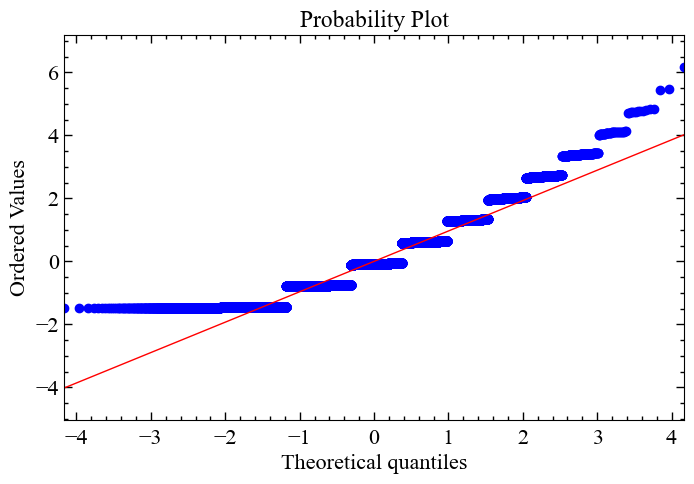

In [57]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

# TODO:
    -LC is aligned with KW
    -Background is estimated
    >> Next: extract the spectrum for the burst for export to fits files
        -If only 64 ms is available, a good area is selected below

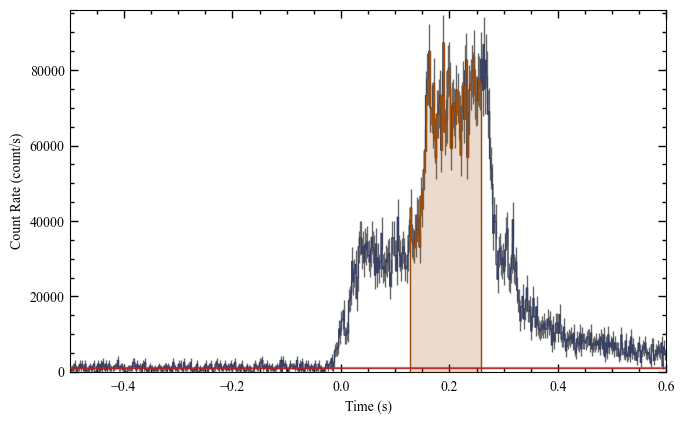

In [58]:
src_time = (0.128,0.256) #Need around 100ms expose for this burst
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

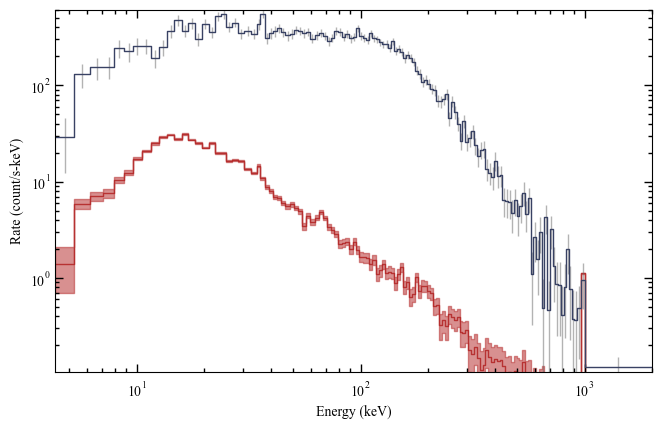

In [59]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = tte.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

In [60]:
# Extract the corresponding PHA from source and bkg files
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

In [61]:
# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")

fparkey GRB181222B_n4.rsp GRB181222B_n4.pha+2 RESPFILE


# Time intervals for spectra

In [21]:
# Add time shift due to GBM vs. KW reference times

#fn_spec_times = '/home/guidorzi/ASIM/KW_LCs/GRB201227A_sp.txt'
#spec_times = np.loadtxt(fn_spec_times, unpack=True) + tshift
